Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


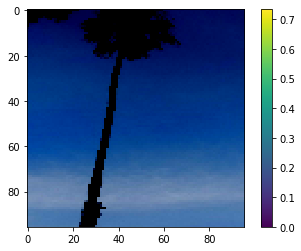

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 27648)             0         
_________________________________________________________________
output_dense_layer (Dense)   (None, 4)                 110596    
Total params: 110,596
Trainable params: 110,596
Non-trainable params: 0
_________________________________________________________________
Train on 52 samples, validate on 13 samples
Epoch 1/10
52/52 [==============================] - 0s 5ms/sample - loss: 2.5314 - accuracy: 0.4808 - val_loss: 0.2325 - val_accuracy: 0.9231
Epoch 2/10
52/52 [==============================] - 0s 713us/sample - loss: 1.1267 - accuracy: 0.7885 - val_loss: 2.3560 - val_accuracy: 0.3846
Epoch 3/10
52/52 [==============================] - 0s 706us/sample - loss: 0.4802 - accuracy: 0.8846 - val_loss: 1.3472 - val_accuracy: 0.5385
Epoch 4/10
52/52 [==================

In [5]:
import tensorflow as tf
from tensorflow import keras

from os import walk

import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 96
BATCH_SIZE = 10
EPOCHS=10

trainingFilesPath = 'VisualRecognitionImages/training/'
scoringFilesPath = 'VisualRecognitionImages/test/'

NB_CLASSES = 4

VERBOSE = 1
VALIDATION_SPLIT = 0.2

train_images = []
scoring_images = []

train_labels = [];
scoring_labels = [];

val_data = [];

# Read in classes based on path structure
def get_model_classes(targetPath):
    for (dirpath, classes, filenames) in walk(targetPath):
        return classes
    
# Read in the names of the image files
def get_file_names(targetPath):
    for (dirpath, classes, filenames) in walk(targetPath):
        return [fi for fi in filenames if fi.endswith(".jpg")]

# Convert the string class name to a numeric index that can be predicted
def get_class_index(className):
    return {
        'Maple Tree': 0,
        'Palm Tree': 1,
        'Podocarpus Tree': 2,
        'Unknown': 3
    }.get(className, 3)

# Load and resize an image so they are all the same size
def load_image(imagePath):
    image_string = tf.io.read_file(imagePath)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
    image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    return image_resized.numpy()

# Execute the load methods
classes = get_model_classes(trainingFilesPath)

for trainingClass in classes:
    files = get_file_names(trainingFilesPath + trainingClass)
    for fileName in files:
        train_labels.append(get_class_index(trainingClass))
        train_images.append(load_image(trainingFilesPath + trainingClass + "/" + fileName))

classes = get_model_classes(scoringFilesPath)
for scoringClass in classes:
    files = get_file_names(scoringFilesPath + scoringClass)
    for fileName in files:
        scoring_labels.append(get_class_index(scoringClass))
        scoring_images.append(load_image(scoringFilesPath + scoringClass + "/" + fileName))
        val_data.append([get_class_index(scoringClass), load_image(scoringFilesPath + scoringClass + "/" + fileName)])

# Show what an image looks like that is ready to use for training
plt.figure()
plt.imshow(train_images[30])
plt.colorbar()
plt.grid(False)
plt.show()

# Convert to array to be used for scoring
train_images = np.array(train_images)
train_labels = np.array(train_labels)
scoring_images = np.array(scoring_images)
scoring_labels = np.array(scoring_labels)

# Put together the perception
model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(keras.layers.Dense(NB_CLASSES, name='output_dense_layer',activation='softmax'))

model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Do the training
model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# See how accurate the model is
test_loss, test_acc = model.evaluate(scoring_images, scoring_labels)
print()
print('Test accuracy:', test_acc)
